In [1]:
import os, sklearn, pandas, numpy as np
from sklearn import svm
import skimage, skimage.io, skimage.filters
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# set cwd back to default
os.chdir('../')
os.getcwd()

'/Users/mark/src/dog-breed-identification/src'

In [3]:
## NN libs
import keras
from sklearn.decomposition import PCA
from keras.utils import to_categorical
from keras.layers import Dense, Activation
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, Conv3D, MaxPool2D, Dropout, Flatten

Using TensorFlow backend.


In [4]:
# custom scripts
import config # params, constants
import data, models # functions that mutate outr data
from utils import utils, plot # custom functions, in local environment

 Dataset :: namedtuple(
    ['train' = ['img_name']
    , 'test' = ['img_name']
    , 'labels' = pandas.df('img_name','breed')
    , 'dict_index_to_label' = dict to convert label_index -> label_name
    , 'dict_label_to_index'= dict to convert label_name -> label_index
    


# Prepare dataset

In [5]:
import data # src/data.py
dataset = data.init_dataset()

In [6]:
# I think the smallest img has shape 160x160
shape = (160,160,3)

In [7]:
# Read data
amt = 50 # amount of train, test data
x_train, y_train, amt1 = data.extract_all(dataset, dataset.train[0:amt])
x_test, y_test, amt2 = data.extract_all(dataset, dataset.train[amt:amt + amt])
amt = amt1
print(amt1,amt2)
data.show_info(x_train)

extract all data: 50
extract all data: 50
43 46
__ info: __
length:  43
type:  <class 'numpy.ndarray'>
shape:  (43, 250, 250, 3)


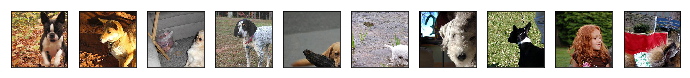

In [8]:
plot.multiple(x_train[:10])

### Prepare the labels

Encode the labels to one-hot vectors

In [9]:
y_train, y_test = data.labels_to_vectors(dataset,y_train, y_test)

In [10]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])

# Train a Sequential model (keras)

In [11]:
n_samples = x_train.shape[0] # = length of the list of images (matrices)
input_shape = x_train.shape[1:] # = shape of an individual image (matrix)
output_length = (y_train[0]).shape[0] # = length of an individual label
print(n_samples, input_shape)
print('output length', output_length)

43 (250, 250, 3)
output length 107


In [12]:
x_train.shape

(43, 250, 250, 3)

In [13]:
input_shape

(250, 250, 3)

In [14]:
def sequential_conv(input_shape, output_length, dropout=0.25):
    model = Sequential()
    model.add(
        Conv2D(
            4, kernel_size=(6, 6), activation='relu',
            input_shape=input_shape))
    model.add(Conv2D(16, (12, 12), activation='relu'))
    model.add(Conv2D(32, (9, 9), activation='relu'))
    # reduce the number of dimensions
    model.add(Conv2D(8, (24, 24), activation='relu'))
    model.add(Conv2D(3, (24, 24), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(
        Dropout(dropout)
    )  # Dropout 25% of the nodes of the previous layer during training
    model.add(Flatten())  # Flatten, and add a fully connected layer
    model.add(Dense(128, activation='relu'))
    # model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout))  # 5 TODO minder dropout?
    model.add(Dense(
        output_length,
        activation='softmax'))  # Last layer: 10 class nodes, with dropout
    return model, model.summary
model, summary = sequential_conv(input_shape, output_length)
summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 245, 245, 4)       436       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 234, 234, 16)      9232      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 226, 226, 32)      41504     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 203, 203, 8)       147464    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 180, 180, 3)       13827     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 90, 90, 3)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 90, 90, 3)         0         
__________

In [15]:
import models # src/models.py

# model, summary = models.sequential_conv(input_shape, output_length)
summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 245, 245, 4)       436       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 234, 234, 16)      9232      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 226, 226, 32)      41504     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 203, 203, 8)       147464    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 180, 180, 3)       13827     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 90, 90, 3)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 90, 90, 3)         0         
__________

## Loss function
- Categorical cross-entropy loss

In [16]:
learning_rate = 0.001
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

## Finally train the model

In [17]:
# Compute a batch size
batch_size = 8
# n epochs = n iterations over all the training data
epochs = 50

In [18]:
import config
config.tmp_model_dir

'/tmp/ml_model'

In [19]:
from keras.callbacks import TensorBoard

In [ ]:
# model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=1/6)
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, 
          validation_split=1/6, callbacks=[TensorBoard(log_dir=config.tmp_model_dir)])

Train on 35 samples, validate on 8 samples
Epoch 1/50
35/35 [==============================] - 237s 7s/step - loss: 7.9612 - acc: 0.0000e+00 - val_loss: 4.6722 - val_acc: 0.0000e+00
Epoch 2/50
35/35 [==============================] - 369s 11s/step - loss: 4.6674 - acc: 0.0286 - val_loss: 4.6715 - val_acc: 0.0000e+00
Epoch 3/50
35/35 [==============================] - 236s 7s/step - loss: 4.6614 - acc: 0.0857 - val_loss: 4.6706 - val_acc: 0.0000e+00
Epoch 4/50
35/35 [==============================] - 207s 6s/step - loss: 4.6552 - acc: 0.0571 - val_loss: 4.6696 - val_acc: 0.0000e+00
Epoch 5/50
35/35 [==============================] - 240s 7s/step - loss: 4.6477 - acc: 0.0286 - val_loss: 4.6687 - val_acc: 0.0000e+00
Epoch 6/50
35/35 [==============================] - 198s 6s/step - loss: 4.6400 - acc: 0.0857 - val_loss: 4.6678 - val_acc: 0.0000e+00
Epoch 7/50
35/35 [==============================] - 196s 6s/step - loss: 4.6332 - acc: 0.0571 - val_loss: 4.6669 - val_acc: 0.0000e+00
Epoch 8

In [ ]:
result = model.predict(x_test[:10])
result

In [ ]:
result[0]

In [ ]:
result[0].argmax()

In [ ]:
result1 = model.predict(x_train[:10])
result1 == y_train